In [1]:
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

In [2]:
# hyperparameters
eps_nbp1 = 300
eps_nbp2 = 300
eps_methyLimp = 3000

In [3]:
# reading data and dropping all rows with missing values
data  = pd.read_csv("../data/filtered_cytosines_freq_preprocessed.tsv", sep='\t')
mask = np.invert(np.any(np.isnan(data.values[:, 2:].astype(np.float64)), axis=1))
data_without_nans = data[mask].reset_index(drop=True)
data_without_nans

,chromosome,position,OD10,OD11,OD12,OD13,OD14,OD15,OD16,OD17,...,YD20,YD21,YD2,YD3,YD4,YD5,YD6,YD7,YD8,YD9
0,chr1,10497,71.956,93.640,94.410,92.163,86.408,92.143,91.304,69.029,...,92.880,80.769,85.714,73.761,84.277,80.408,94.667,92.623,83.992,89.620
1,chr1,10525,93.704,90.813,95.679,89.375,93.528,95.714,93.103,89.737,...,90.000,87.179,91.081,91.329,92.332,85.537,92.857,89.617,92.073,94.684
2,chr1,10542,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,...,100.000,100.000,100.000,100.000,100.000,100.000,99.647,99.708,99.781,100.000
3,chr1,133165,98.649,100.000,100.000,97.436,78.571,93.151,100.000,67.010,...,100.000,97.059,95.385,82.927,100.000,98.630,100.000,100.000,100.000,94.828
4,chr1,133180,95.946,100.000,100.000,97.436,91.228,88.732,96.970,98.958,...,100.000,100.000,84.127,97.297,94.231,88.571,93.617,92.453,85.185,98.182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482677,chrY,59021089,60.563,75.000,90.000,61.429,92.754,56.190,56.604,100.000,...,69.565,65.000,66.038,64.368,72.000,49.275,48.750,80.769,83.333,80.645
2482678,chrY,59026010,85.714,80.247,84.615,80.117,90.909,84.946,81.818,91.045,...,87.234,81.522,77.193,83.065,87.059,77.143,82.308,88.889,77.838,76.923
2482679,chrY,59033031,78.431,91.827,90.196,89.286,84.000,80.000,89.744,72.581,...,90.385,79.592,91.667,94.118,66.667,100.000,95.000,94.737,86.047,85.246
2482680,chrY,59033041,79.167,97.101,86.275,85.185,92.593,92.000,84.615,82.258,...,87.821,83.838,85.714,87.500,88.235,85.714,95.000,73.684,85.366,90.000


In [4]:
# dropping some rows
# these are rows for testing

n, m = data_without_nans.shape

row_inds = np.random.choice(np.arange(n), size=n // 1000, replace=False)

data_without_rows = data_without_nans.drop(row_inds).reset_index(drop=True)

In [5]:
# puting 1 percent missing values in the data

n, m = data_without_rows.shape

nans_mask = np.random.choice([True, False], size=(n, m-2), p=[0.01, 0.99])
nans_mask = np.concatenate((np.zeros((n, 2), dtype=bool), nans_mask), axis=1)
data_with_nans = data_without_rows.copy()
data_with_nans[nans_mask] = np.nan
data_with_nans.head()

,chromosome,position,OD10,OD11,OD12,OD13,OD14,OD15,OD16,OD17,...,YD20,YD21,YD2,YD3,YD4,YD5,YD6,YD7,YD8,YD9
0,chr1,10497,71.956,93.640,94.410,92.163,86.408,92.143,91.304,69.029,...,92.88,80.769,85.714,73.761,84.277,80.408,94.667,92.623,83.992,89.620
1,chr1,10525,93.704,90.813,95.679,89.375,93.528,95.714,93.103,89.737,...,90.00,87.179,91.081,91.329,92.332,85.537,92.857,89.617,92.073,94.684
2,chr1,10542,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,...,100.00,100.000,100.000,100.000,100.000,100.000,99.647,99.708,99.781,100.000
3,chr1,133165,98.649,100.000,NaN,97.436,78.571,93.151,100.000,67.010,...,100.00,97.059,95.385,82.927,100.000,98.630,100.000,100.000,100.000,94.828
4,chr1,133180,95.946,100.000,100.000,97.436,91.228,88.732,96.970,NaN,...,100.00,100.000,84.127,97.297,94.231,88.571,93.617,92.453,85.185,98.182


In [6]:
# finding slices for imputation rows

slices = []

chromosome_coords = utils.get_chromosome_coords(data_with_nans.chromosome)
positions = data_with_nans.position.values

for row in row_inds:
    c = data_without_nans.chromosome[row]
    p = data_without_nans.position[row]
    i, j = chromosome_coords[c]
    l, r = utils.find_slice(p, eps_nbp2, positions[i:j])
    slices.append((l + i, r + i))

In [7]:
# rows which are going to be used for row imputation, therefore missing values in these rows have to be imputed
rows_to_impute = np.zeros(len(data_with_nans), dtype=bool)
for l, r in slices:
    rows_to_impute[l:r] = True

# which missing values have to be imputed
impute_nans_mask = nans_mask & rows_to_impute[:, None]


In [8]:
rows_to_impute.sum()

73541

# First methyLimp

In [9]:
# imputation with methyLimp
imputed_data_methyLimp = utils.new_methyLImp(data_with_nans, eps=eps_methyLimp, rows=rows_to_impute & np.any(nans_mask, axis=1))


100%|██████████| 25/25 [07:11<00:00, 17.27s/it]

number of used methylations: 969600
29326 of them imputed by methyLImp


# First nbp

In [10]:
# imputation with methyLimp
imputed_data_nbp = utils.impute_1000bp(data_with_nans, eps=eps_nbp1, impute_positions=impute_nans_mask[:, 2:])

  5%|▍         | 1408/29326 [00:00<00:03, 7094.57it/s]/Users/Emiliia.Lekhman/Desktop/project/tests/utils/imputation.py:131: RuntimeWarning: Mean of empty slice
  imputed_data.loc[row, columns[col + 2]] = np.nanmean(values[left:right, col])
100%|██████████| 29326/29326 [00:03<00:00, 7379.61it/s]


# Row imputation

In [11]:
def impute_rows(imputed_data):
    rows = []
    for i, j in slices:
        rows.append(np.mean(imputed_data[i:j], axis=0))
    return np.array(rows)

true_row_values = data_without_nans.iloc[row_inds].values[:, 2:]

In [12]:
# impute rows with first step methyLimp imputation
diffs = true_row_values - impute_rows(imputed_data_methyLimp)
print("rmse")
print(np.mean(diffs ** 2) ** 0.5)
print("\nmae")
print(np.mean(np.abs(diffs)))

rmse
13.263409631069205

mae
6.179893889931834


In [13]:
# impute rows with first step nbp imputation
diffs = true_row_values - impute_rows(imputed_data_nbp.values[:, 2:].astype(np.float64))
print("rmse")
print(np.mean(diffs ** 2) ** 0.5)
print("\nmae")
print(np.mean(np.abs(diffs)))

rmse
13.41580096607904

mae
6.225346096976917


# Different missing values percent

In [14]:
rmse_methyLimp_lst = []
mae_methyLimp_lst = []

rmse_nbp_lst = []
mae_nbp_lst = []

for p in np.linspace(0.01, 0.2, 10):
    print(f"missing values percent: {p}")
    
    nans_mask = np.random.choice([True, False], size=(n, m-2), p=[p, 1 - p])
    nans_mask = np.concatenate((np.zeros((n, 2), dtype=bool), nans_mask), axis=1)
    data_with_nans = data_without_rows.copy()
    data_with_nans[nans_mask] = np.nan
    data_with_nans.head()

    imputed_data_methyLimp = utils.new_methyLImp(data_with_nans, eps=eps_methyLimp, rows=rows_to_impute & np.any(nans_mask, axis=1))
    
    diffs_methyLimp = true_row_values - impute_rows(imputed_data_methyLimp)
    rmse_methyLimp_lst.append(np.mean(diffs_methyLimp ** 2) ** 0.5)
    mae_methyLimp_lst.append(np.mean(np.abs(diffs_methyLimp)))
    

    imputed_data_nbp = utils.impute_1000bp(data_with_nans, eps=eps_nbp1, impute_positions=impute_nans_mask[:, 2:])

    diffs_nbp = true_row_values - impute_rows(imputed_data_nbp.values[:, 2:].astype(np.float64))
    rmse_nbp_lst.append(np.mean(diffs_nbp ** 2) ** 0.5)
    mae_nbp_lst.append(np.mean(np.abs(diffs_nbp)))

missing values percent: 0.01


100%|██████████| 25/25 [07:27<00:00, 17.88s/it]


number of used methylations: 971480
29429 of them imputed by methyLImp


100%|██████████| 29326/29326 [00:04<00:00, 6959.05it/s]


missing values percent: 0.03111111111111111


100%|██████████| 25/25 [09:23<00:00, 22.55s/it]


number of used methylations: 2112480
91649 of them imputed by methyLImp


100%|██████████| 29326/29326 [00:04<00:00, 7029.28it/s]


missing values percent: 0.052222222222222225


100%|██████████| 25/25 [07:41<00:00, 18.47s/it]


number of used methylations: 2597560
153680 of them imputed by methyLImp


100%|██████████| 29326/29326 [00:04<00:00, 7042.49it/s]


missing values percent: 0.07333333333333333


100%|██████████| 25/25 [05:52<00:00, 14.12s/it]


number of used methylations: 2801320
215066 of them imputed by methyLImp


100%|██████████| 29326/29326 [00:04<00:00, 7008.07it/s]


missing values percent: 0.09444444444444444


100%|██████████| 25/25 [04:04<00:00,  9.78s/it]


number of used methylations: 2886280
277964 of them imputed by methyLImp


100%|██████████| 29326/29326 [00:04<00:00, 7188.59it/s]


missing values percent: 0.11555555555555555


100%|██████████| 25/25 [04:01<00:00,  9.64s/it]


number of used methylations: 2920160
340157 of them imputed by methyLImp


100%|██████████| 29326/29326 [00:04<00:00, 6946.93it/s]


missing values percent: 0.1366666666666667


100%|██████████| 25/25 [03:47<00:00,  9.10s/it]


number of used methylations: 2933000
401487 of them imputed by methyLImp


100%|██████████| 29326/29326 [00:04<00:00, 7020.08it/s]


missing values percent: 0.1577777777777778


100%|██████████| 25/25 [03:21<00:00,  8.07s/it]


number of used methylations: 2938320
463454 of them imputed by methyLImp


100%|██████████| 29326/29326 [00:04<00:00, 7130.28it/s]


missing values percent: 0.1788888888888889


100%|██████████| 25/25 [03:23<00:00,  8.13s/it]


number of used methylations: 2940080
526155 of them imputed by methyLImp


100%|██████████| 29326/29326 [00:04<00:00, 7133.58it/s]


missing values percent: 0.2


100%|██████████| 25/25 [03:13<00:00,  7.74s/it]


number of used methylations: 2941360
589585 of them imputed by methyLImp


100%|██████████| 29326/29326 [00:04<00:00, 7088.61it/s]


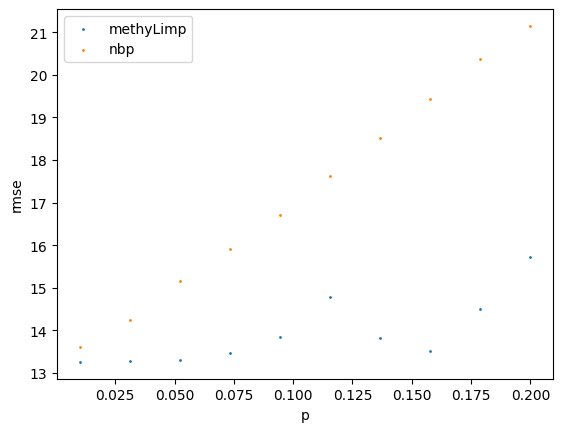

In [15]:
plt.scatter(np.linspace(0.01, 0.2, 10), rmse_methyLimp_lst, s=1, label="methyLimp")
plt.scatter(np.linspace(0.01, 0.2, 10), rmse_nbp_lst, s=1, label="nbp")
plt.xlabel("p")
plt.ylabel("rmse")
plt.legend()
plt.show()

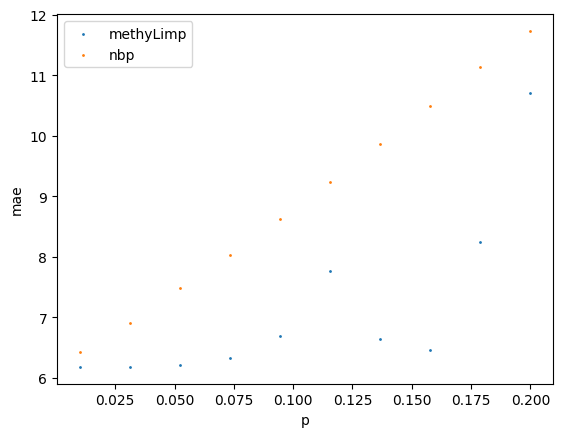

In [16]:
plt.scatter(np.linspace(0.01, 0.2, 10), mae_methyLimp_lst, s=1, label="methyLimp")
plt.scatter(np.linspace(0.01, 0.2, 10), mae_nbp_lst, s=1, label="nbp")
plt.xlabel("p")
plt.ylabel("mae")
plt.legend()
plt.show()